# Exploratory Data Analysis on PWM Behavioral Data

**Goal** This notebook will explore the new dataset to see what trends are present now that violations are properly tracked and timeouts are not incorrectly marked as violations.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd

from multiglm.data.dataset_loader import *
from multiglm.data import ANIMAL_IDS

sns.set_context("talk")

%load_ext autoreload
%autoreload 2

choice_palette = sns.color_palette("Set2", 3)

## Load In

In [4]:
full_df = DatasetLoader(
    animal_ids=ANIMAL_IDS,
    data_type="new_all",
).load_data()
trained_df = DatasetLoader(
    animal_ids=ANIMAL_IDS,
    data_type="new_trained",
).load_data()

Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']
Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


## Sessions

In [4]:
trial_counts = (
    full_df.groupby(["training_stage", "animal_id"]).size().reset_index(name="count")
)

merged_counts = pd.merge(
    full_df.groupby(["animal_id", "training_stage"])["session"].nunique().reset_index(),
    trial_counts,
    on=["animal_id", "training_stage"],
)

merged_counts = pd.merge(
    full_df.groupby(["training_stage", "animal_id", "session"])
    .trial.max()
    .reset_index()
    .groupby(["training_stage", "animal_id"])
    .trial.mean()
    .reset_index(),
    merged_counts,
    on=["animal_id", "training_stage"],
)

merged_counts.head()

,training_stage,animal_id,trial,session,count
0,1,W051,244.157895,19,4639
1,1,W060,228.062500,32,7298
2,1,W065,228.105263,19,4334
3,1,W066,221.294118,17,3762
4,1,W068,207.842105,19,3949


Text(0.5, 1.0, 'N trials per Session')

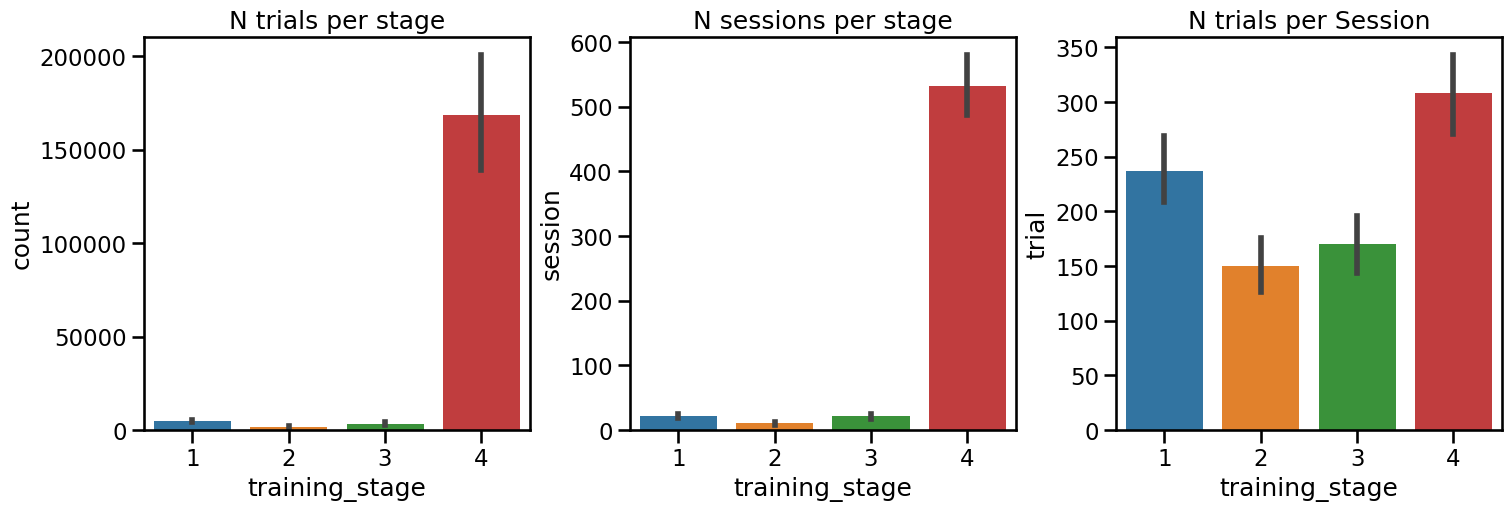

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)


sns.barplot(merged_counts, x="training_stage", y="count", ax=ax[0])
ax[0].set_title("N trials per stage")


sns.barplot(data=merged_counts, x="training_stage", y="session", ax=ax[1])
ax[1].set_title("N sessions per stage")

sns.barplot(data=merged_counts, x="training_stage", y="trial", ax=ax[2])
ax[2].set_title("N trials per Session")

### Trained DF Stats

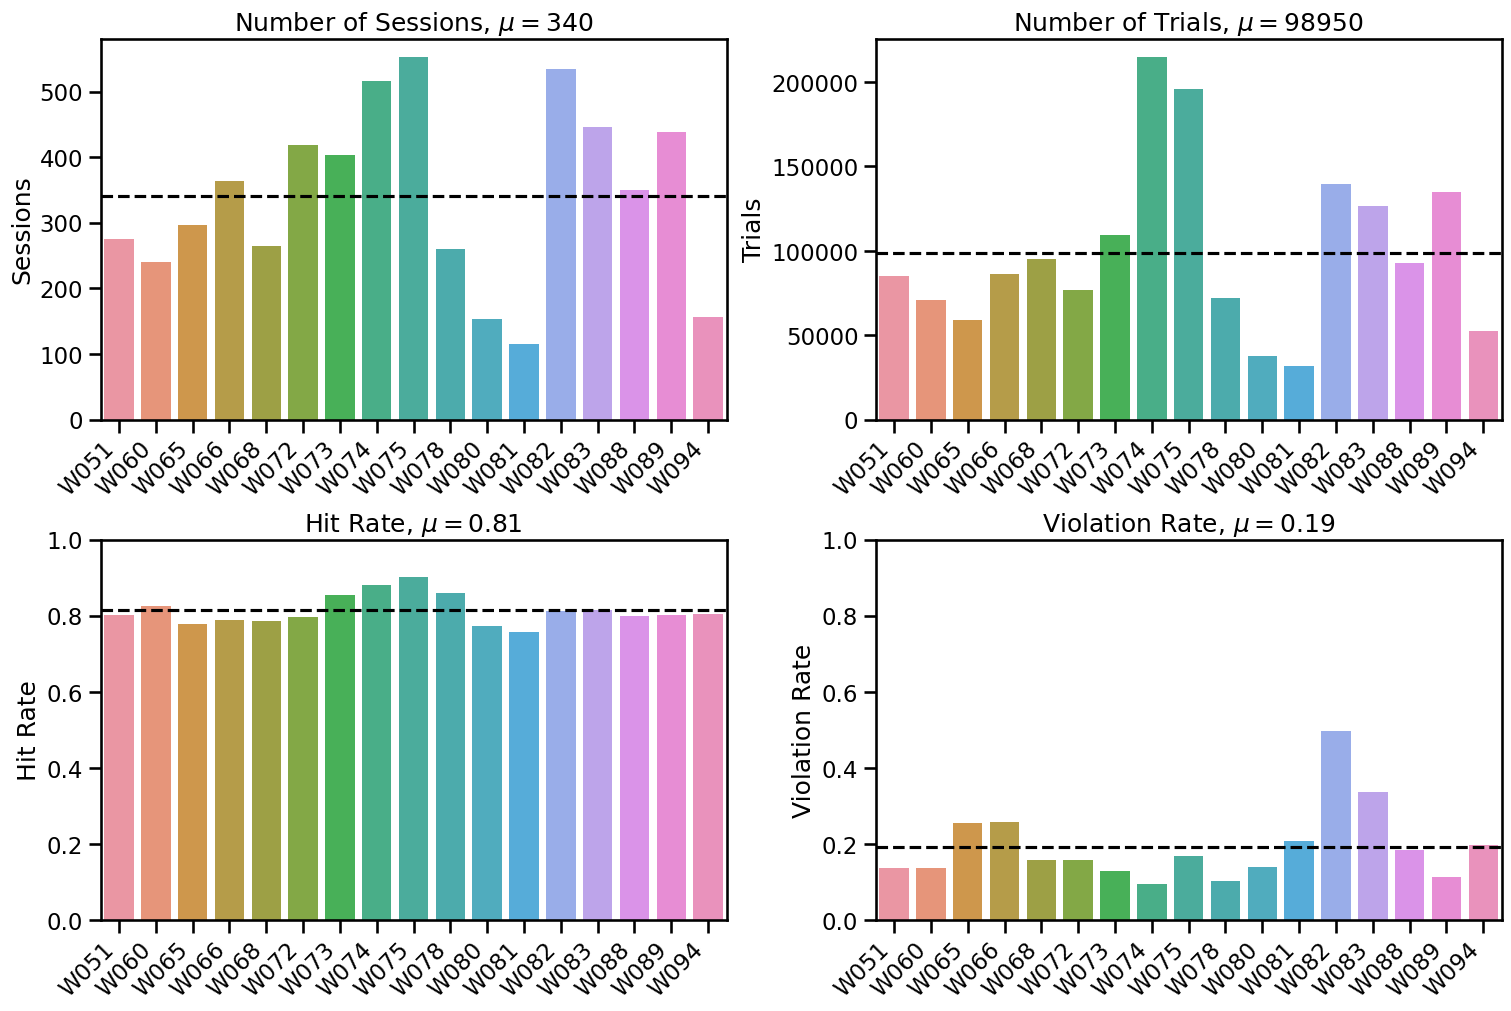

In [10]:
trained_df_count_stats = pd.read_csv(
    "../data/processed/dataset_thresholding/trained_threshold_df_stats.csv"
)

fig, ax = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)


plot_df = trained_df_count_stats

sns.barplot(x="animal_id", y="n_sessions", data=plot_df, ax=ax[0, 0])
session_mean = plot_df.n_sessions.mean()
ax[0, 0].axhline(session_mean, color="k", linestyle="--")
_ = ax[0, 0].set(
    title=f"Number of Sessions, $\mu = ${session_mean:.0f}",
    xlabel="",
    ylabel="Sessions",
)

sns.barplot(x="animal_id", y="n_trials", data=plot_df, ax=ax[0, 1])
trials_mean = plot_df.n_trials.mean()
ax[0, 1].axhline(trials_mean, color="k", linestyle="--")
_ = ax[0, 1].set(
    title=f"Number of Trials, $\mu= ${trials_mean:.0f}", xlabel="", ylabel="Trials"
)


sns.barplot(x="animal_id", y="avg_hit", data=plot_df, ax=ax[1, 0])
hit_mean = plot_df.avg_hit.mean()
ax[1, 0].axhline(hit_mean, color="k", linestyle="--")
_ = ax[1, 0].set(
    title=f"Hit Rate, $\mu = ${hit_mean:.2f}", xlabel="", ylabel="Hit Rate", ylim=(0, 1)
)

sns.barplot(x="animal_id", y="avg_violation", data=plot_df, ax=ax[1, 1])
violation_mean = plot_df.avg_violation.mean()
ax[1, 1].axhline(violation_mean, color="k", linestyle="--")
_ = ax[1, 1].set(
    title=f"Violation Rate, $\mu = ${violation_mean:.2f}",
    xlabel="",
    ylabel="Violation Rate",
    ylim=(0, 1),
)

for a in ax.flatten():
    _ = a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="right")

## Hit Rates


In [16]:
session_hit_by_stage = (
    full_df.groupby(["animal_id", "training_stage", "session"])
    .hit.mean()
    .reset_index()
    .groupby(["animal_id", "training_stage"])
    .hit.mean()
    .reset_index()
)
session_hit_by_stage.head()

,animal_id,training_stage,hit
0,W051,1,0.973147
1,W051,2,0.995332
2,W051,3,0.517187
3,W051,4,0.739582
4,W060,1,0.938054


[Text(0.5, 1.0, 'Hit Rate by Stage'),
 Text(0.5, 0, 'Training Stage'),
 Text(0, 0.5, 'Hit Rate'),
 (0.0, 1.0)]

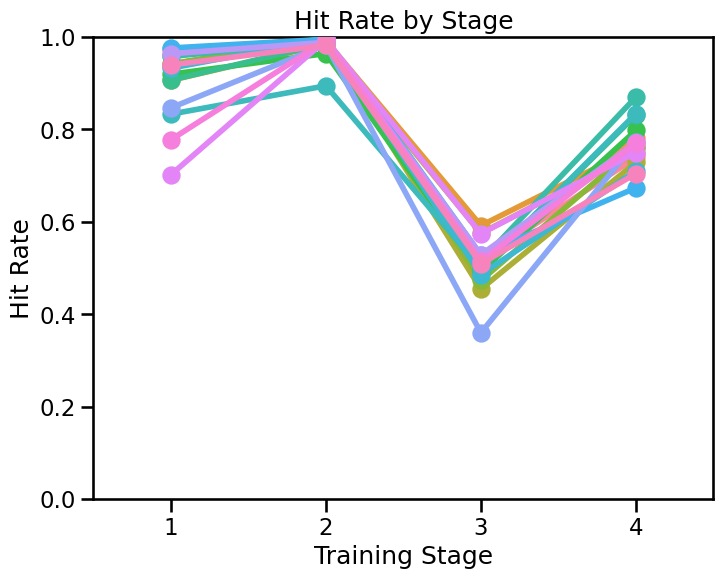

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(
    x="training_stage", y="hit", hue="animal_id", data=session_hit_by_stage, ax=ax
)
ax.legend_.remove()

ax.set(
    title="Hit Rate by Stage",
    xlabel="Training Stage",
    ylabel="Session Avg. Hit Rate",
    ylim=(0, 1),
)

Hit rates are high in stage 1 and 2 due to light guidance, plummet in stage 3 and then climb back to final performance in stage 4.

## Violation Rates

- over stages by animal (save data out)

In [22]:
session_violation_by_stage = (
    full_df.groupby(["animal_id", "training_stage", "session"])
    .violation.mean()
    .reset_index()
    .groupby(["animal_id", "training_stage"])
    .violation.mean()
    .reset_index()
)
session_violation_by_stage.head()

,animal_id,training_stage,violation
0,W051,1,0.193562
1,W051,2,0.173270
2,W051,3,0.273946
3,W051,4,0.154241
4,W060,1,0.257598


[Text(0.5, 1.0, 'Violation Rate by Stage'),
 Text(0.5, 0, 'Training Stage'),
 Text(0, 0.5, 'Session Avg. Violation Rate'),
 (0.0, 1.0)]

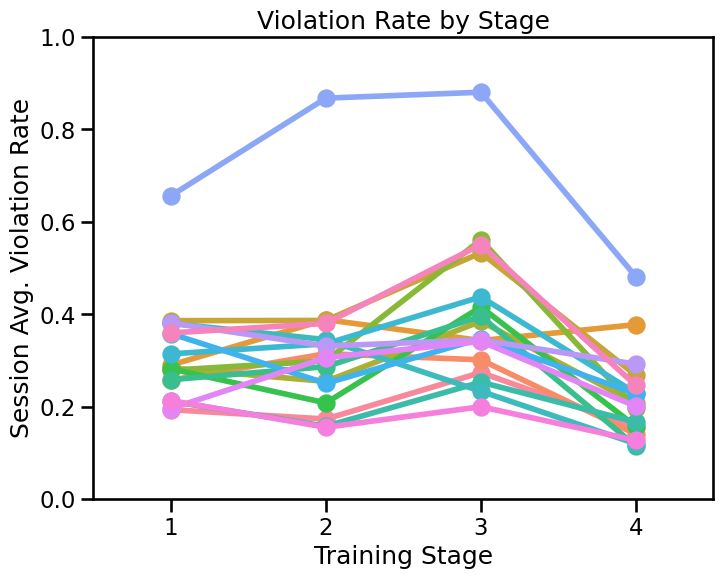

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(
    x="training_stage",
    y="violation",
    hue="animal_id",
    data=session_violation_by_stage,
    ax=ax,
)
ax.legend_.remove()

ax.set(
    title="Violation Rate by Stage",
    xlabel="Training Stage",
    ylabel="Session Avg. Violation Rate",
    ylim=(0, 1),
)

Over time, violation rates drop. Interestingly, they do appear to rise in stage 3 when the hit rates also drop. Perhaps violations are more likely during learning due to frustration/decreased motivation.

## Hit & Violation

### By Stage

In [38]:
hit_viols_by_stage = pd.merge(
    session_hit_by_stage, session_violation_by_stage, on=["animal_id", "training_stage"]
)

hit_viols_by_stage.to_csv(
    "../data/processed/from_eda/01_session_avg_hit_viols_by_stage.csv", index=False
)

hit_viols_by_stage.head()

,animal_id,training_stage,hit,violation
0,W051,1,0.973147,0.193562
1,W051,2,0.995332,0.173270
2,W051,3,0.517187,0.273946
3,W051,4,0.739582,0.154241
4,W060,1,0.938054,0.257598


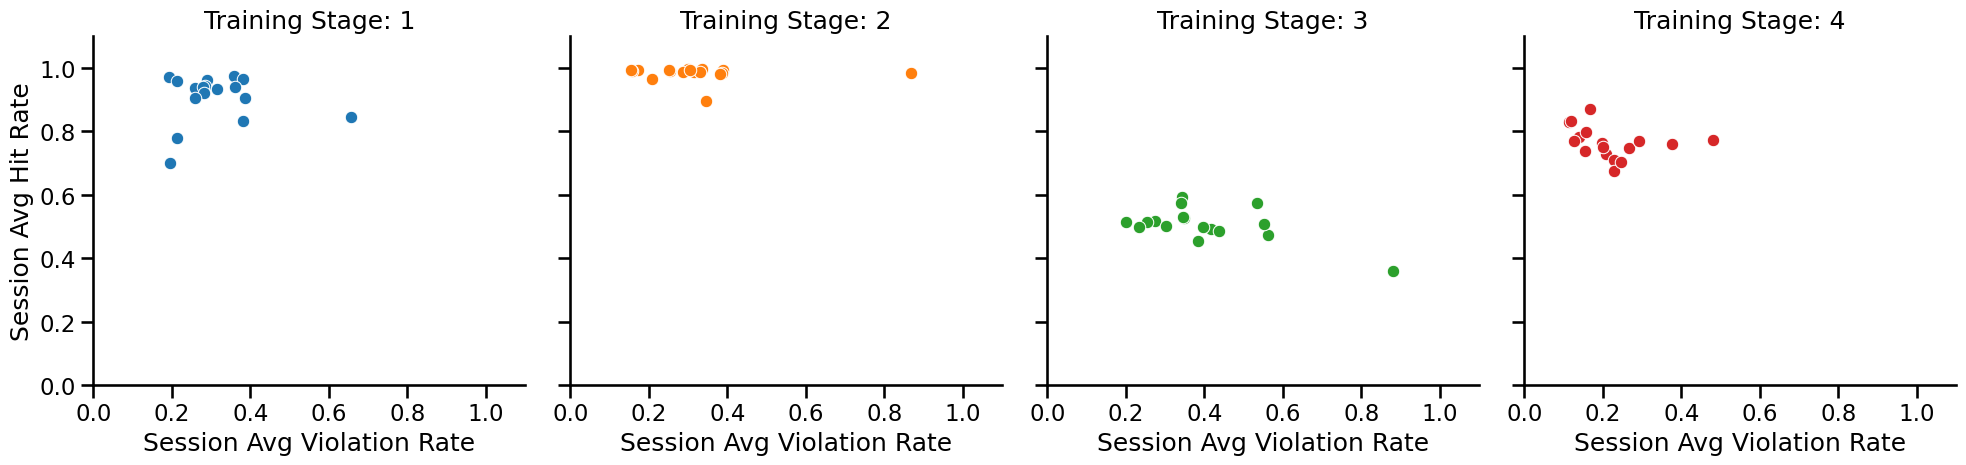

In [32]:
g = sns.FacetGrid(
    data=hit_viols_by_stage,
    col="training_stage",
    hue="training_stage",
    sharey=True,
    sharex=True,
    height=5,
    aspect=1,
    xlim=(0, 1.1),
    ylim=(0, 1.1),
)
g.map(sns.scatterplot, "violation", "hit")

g.set_axis_labels(x_var="Session Avg Violation Rate", y_var="Session Avg Hit Rate")
g.set_titles("Training Stage: {col_name}")

Stage 1, 2 and 4 do not appear to have a correlation between violation rate and hit rates. Stage 3 does appear to, but this seems to be largely driven by the outlier with violation rates > 0.8.

### Trained Data

In [42]:
trained_hit_viol_rates = (
    trained_df.groupby(["animal_id", "session"])
    .agg({"hit": "mean", "violation": "mean"})
    .reset_index()
    .groupby(["animal_id"])
    .agg({"hit": "mean", "violation": "mean"})
    .rename(columns={"hit": "", "violation": "trained_violation"})
    .reset_index()
)


trained_hit_viol_rates.to_csv(
    "../data/processed/from_eda/01_trained_session_avg_hit_viol_rates.csv", index=False
)

trained_hit_viol_rates.head()

,animal_id,trained_hit,trained_violation
0,W051,0.796836,0.154370
1,W060,0.825368,0.149891
2,W065,0.775634,0.260626
3,W066,0.788768,0.253332
4,W068,0.778252,0.163857


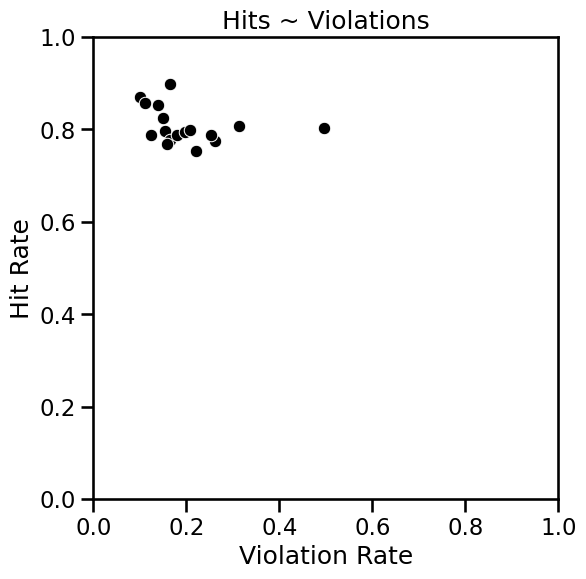

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    data=trained_hit_viol_rates,
    y="trained_hit",
    x="trained_violation",
    color="k",
    ax=ax,
)

_ = ax.set(
    ylabel="Hit Rate",
    xlabel="Violation Rate",
    title="Hits ~ Violations",
    ylim=(0, 1),
    xlim=(0, 1),
)

There does not appear to be a strong relationship between violation rate and hit rate

### Stage Perf Predicting Final Hit Rate

In [49]:
hit_viol_training_and_trained = pd.merge(
    hit_viols_by_stage, trained_hit_viol_rates, how="left", on="animal_id"
)

hit_viol_training_and_trained.head()

,animal_id,training_stage,hit,violation,trained_hit,trained_violation
0,W051,1,0.973147,0.193562,0.796836,0.154370
1,W051,2,0.995332,0.173270,0.796836,0.154370
2,W051,3,0.517187,0.273946,0.796836,0.154370
3,W051,4,0.739582,0.154241,0.796836,0.154370
4,W060,1,0.938054,0.257598,0.825368,0.149891


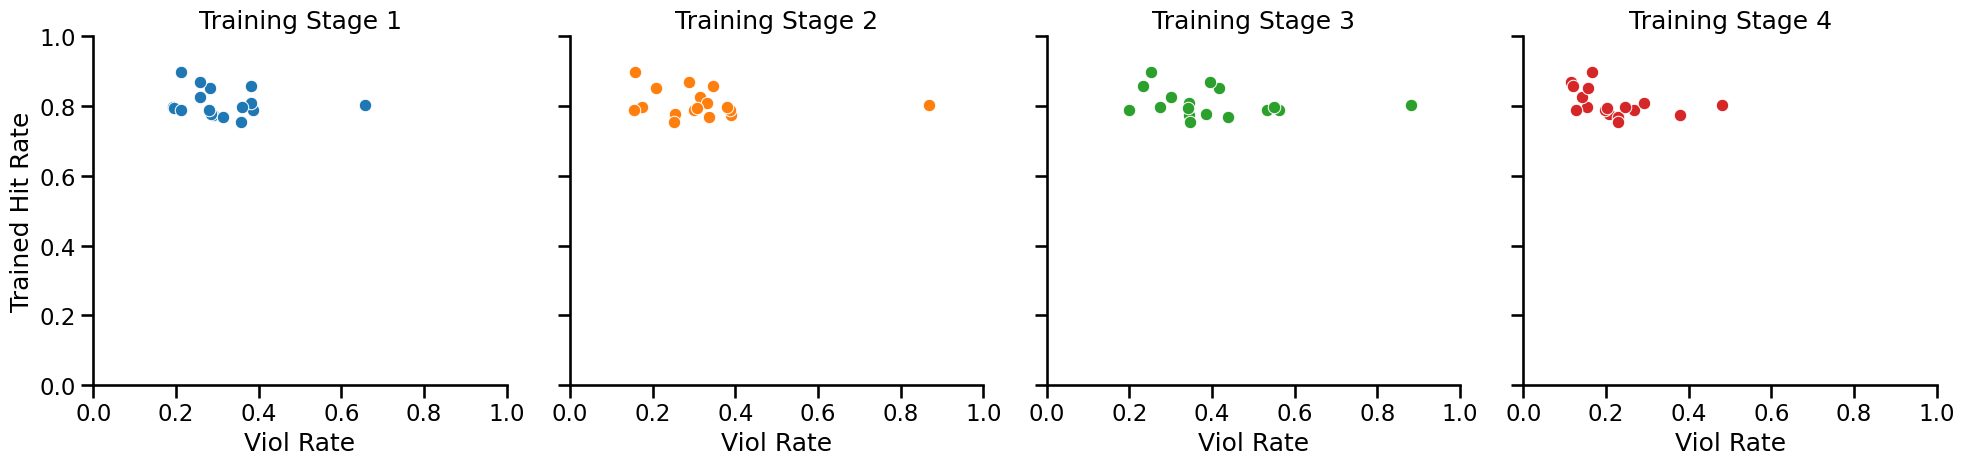

In [51]:
g = sns.FacetGrid(
    data=hit_viol_training_and_trained,
    col="training_stage",
    hue="training_stage",
    sharey=True,
    sharex=True,
    height=5,
    aspect=1,
    xlim=(0, 1),
    ylim=(0, 1),
)
g.map(sns.scatterplot, "violation", "trained_hit")

g.set_axis_labels(x_var="Viol Rate", y_var="Trained Hit Rate")
g.set_titles("Training Stage {col_name}")

### Post Violation Hit Rate

In [33]:
# Step 1: Add Prev Violation Column
def calculate_prev_violation(group):
    session_boundaries_mask = group["session"].diff() == 0
    group["prev_violation"] = (
        group["violation"].shift() * session_boundaries_mask
    ).fillna(0)
    return group


trained_df = (
    trained_df.groupby("animal_id")
    .apply(calculate_prev_violation)
    .reset_index(drop=True)
)

In [34]:
# Step 2: Calculate Hit Rate Post Violation or not
viol_hit_rates = (
    trained_df.groupby(["animal_id", "session", "prev_violation"])
    .hit.mean()
    .reset_index()
    .groupby(["animal_id", "prev_violation"])
    .hit.mean()
    .reset_index()
    .rename({"hit": "hit_rate"}, axis=1)
)

viol_hit_rates.head()

,animal_id,prev_violation,hit_rate
0,W051,0.0,0.803490
1,W051,1.0,0.764054
2,W060,0.0,0.830631
3,W060,1.0,0.783092
4,W065,0.0,0.776971


In [36]:
# Step 3: Turn long form -> Wide Form to plot each column
wide_hit_rates = viol_hit_rates.pivot(
    index="animal_id", columns="prev_violation", values="hit_rate"
)

wide_hit_rates.columns = ["hit_rate_no_prev_viol", "hit_rate_with_prev_viol"]

wide_hit_rates.reset_index(inplace=True)

wide_hit_rates.to_csv(
    "../data/processed/from_eda/01_post_viol_hit_rates.csv", index=False
)
wide_hit_rates.head()

,animal_id,hit_rate_no_prev_viol,hit_rate_with_prev_viol
0,W051,0.803490,0.764054
1,W060,0.830631,0.783092
2,W065,0.776971,0.767371
3,W066,0.787902,0.792920
4,W068,0.779370,0.771608


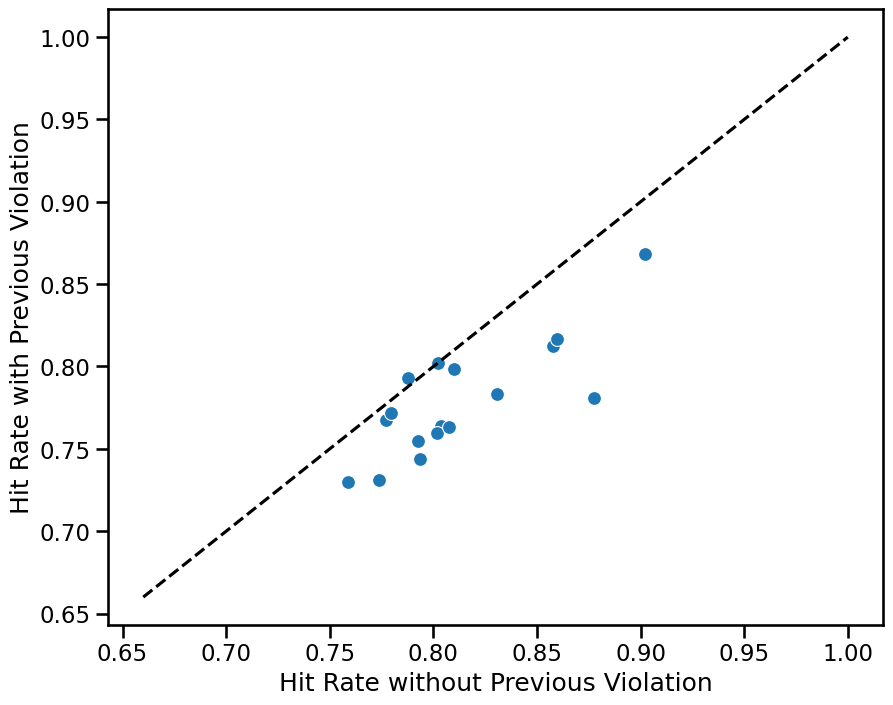

In [37]:
limits = (0.66, 1)
# Scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=wide_hit_rates, x="hit_rate_no_prev_viol", y="hit_rate_with_prev_viol", s=100
)

plt.plot(limits, limits, "k--", label="Unity Line")

plt.xlabel("Hit Rate without Previous Violation")
plt.ylabel("Hit Rate with Previous Violation")

plt.show()

Similar to what I saw in previous modeling results (but more extreme with this new dataset), hit rates immediately after a violation are lowers than those without. This suggests the interaction term will be important again.

## Number of Delays


In [31]:
# get unique delay values for each animal
delay_stats = (
    full_df.query("training_stage > 3")
    .groupby("animal_id")
    .delay_time.unique()
    .reset_index()
)

# get the number of unique delay values for each animal
delay_stats["n_unique_delays"] = delay_stats.delay_time.apply(lambda x: len(x))
delay_stats["avg_delay_time"] = delay_stats.animal_id.map(
    full_df.query("training_stage > 3").groupby("animal_id").delay_time.mean()
)

delay_stats.to_csv("../data/processed/from_eda/01_delay_stats.csv", index=False)
delay_stats.head()

,animal_id,delay_time,n_unique_delays,avg_delay_time
0,W051,"[2.0, 4.0, 3.0, 6.0, 5.0]",5,3.396924
1,W060,"[2.0, 3.0, 4.0, 6.0]",4,3.133262
2,W065,"[3.0, 2.0, 4.0, 6.0]",4,3.700947
3,W066,"[3.0, 2.0, 4.0, 6.0, 5.0, 8.0, 7.0]",7,4.349539
4,W068,"[3.0, 2.0, 4.0, 6.0]",4,3.438329


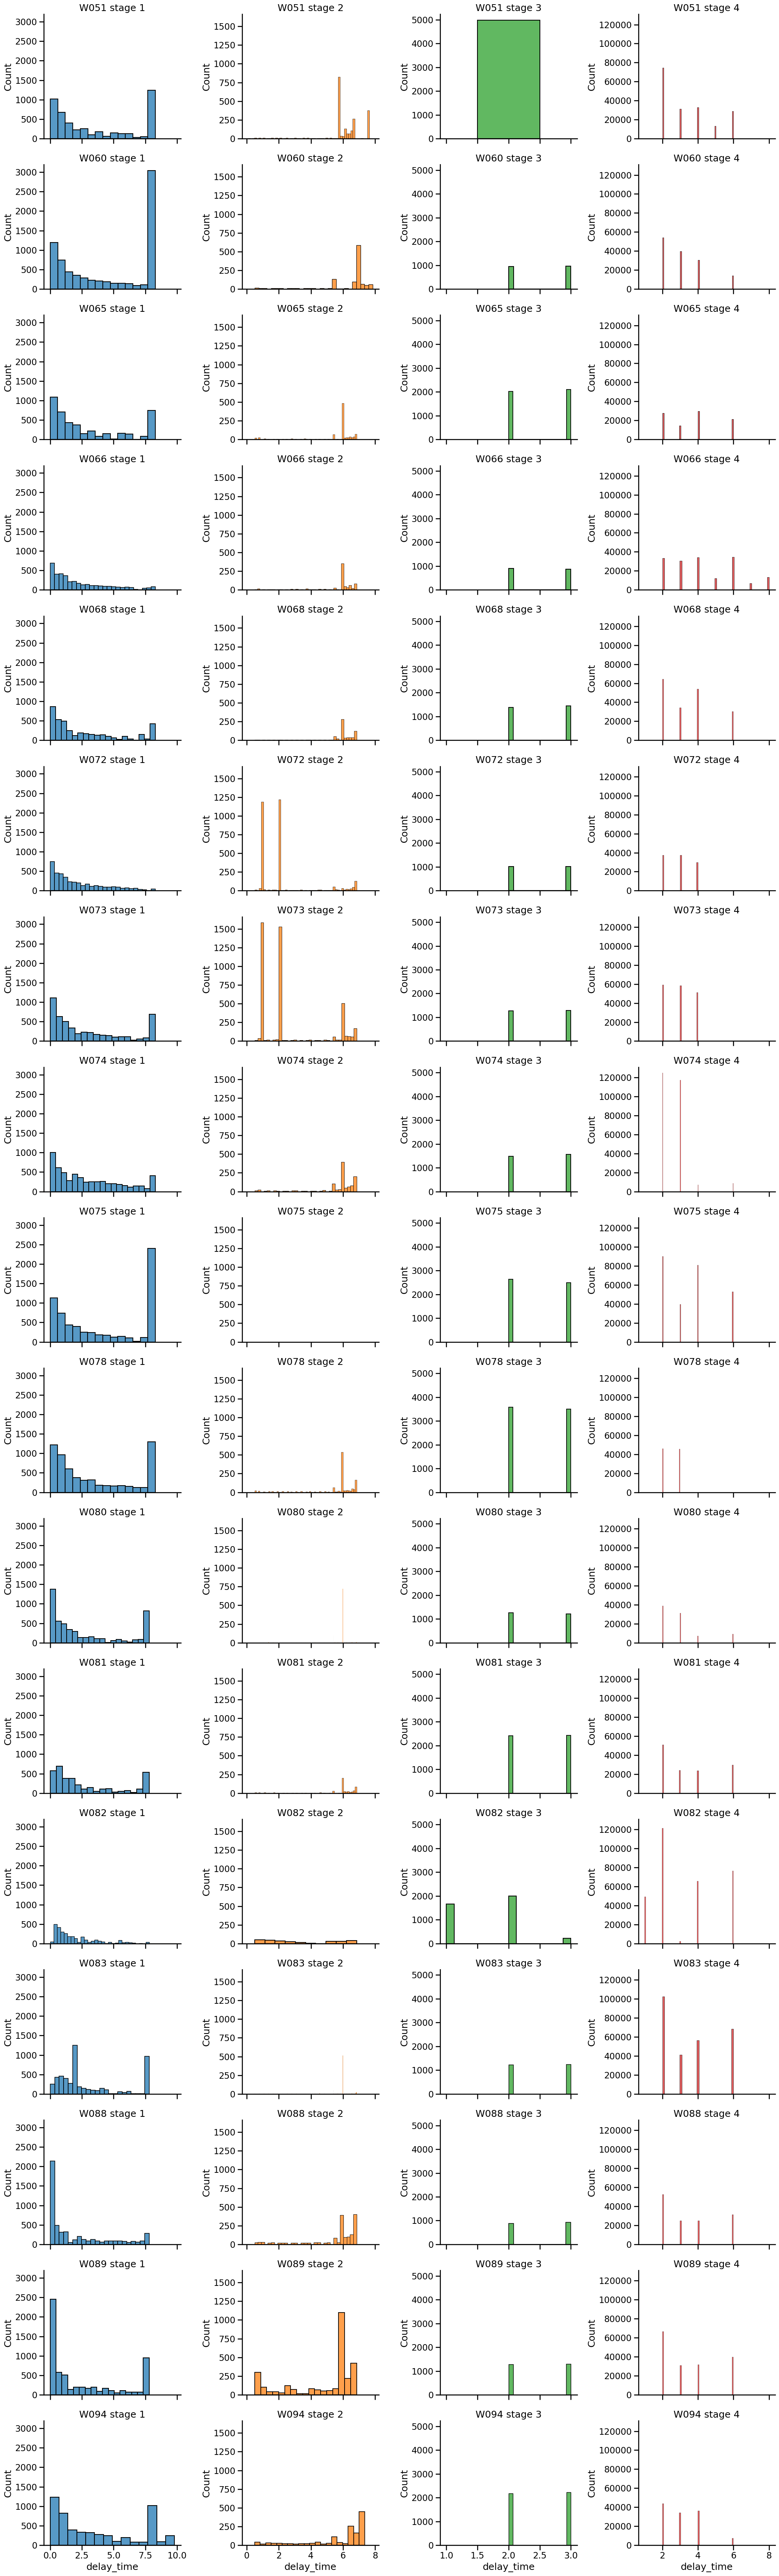

In [17]:
g = sns.FacetGrid(
    data=full_df,
    row="animal_id",
    col="training_stage",
    hue="training_stage",
    sharey="col",
    sharex="col",
    height=4,
    aspect=1.3,
)
g.map(sns.histplot, "delay_time")
g.set_titles("{row_name} stage {col_name}")

It appears that most of the delay variation comes from stage 1 and 2 during gnp. However, in stage 4 there is a quite a bit of variation in delay lengths for each animal.

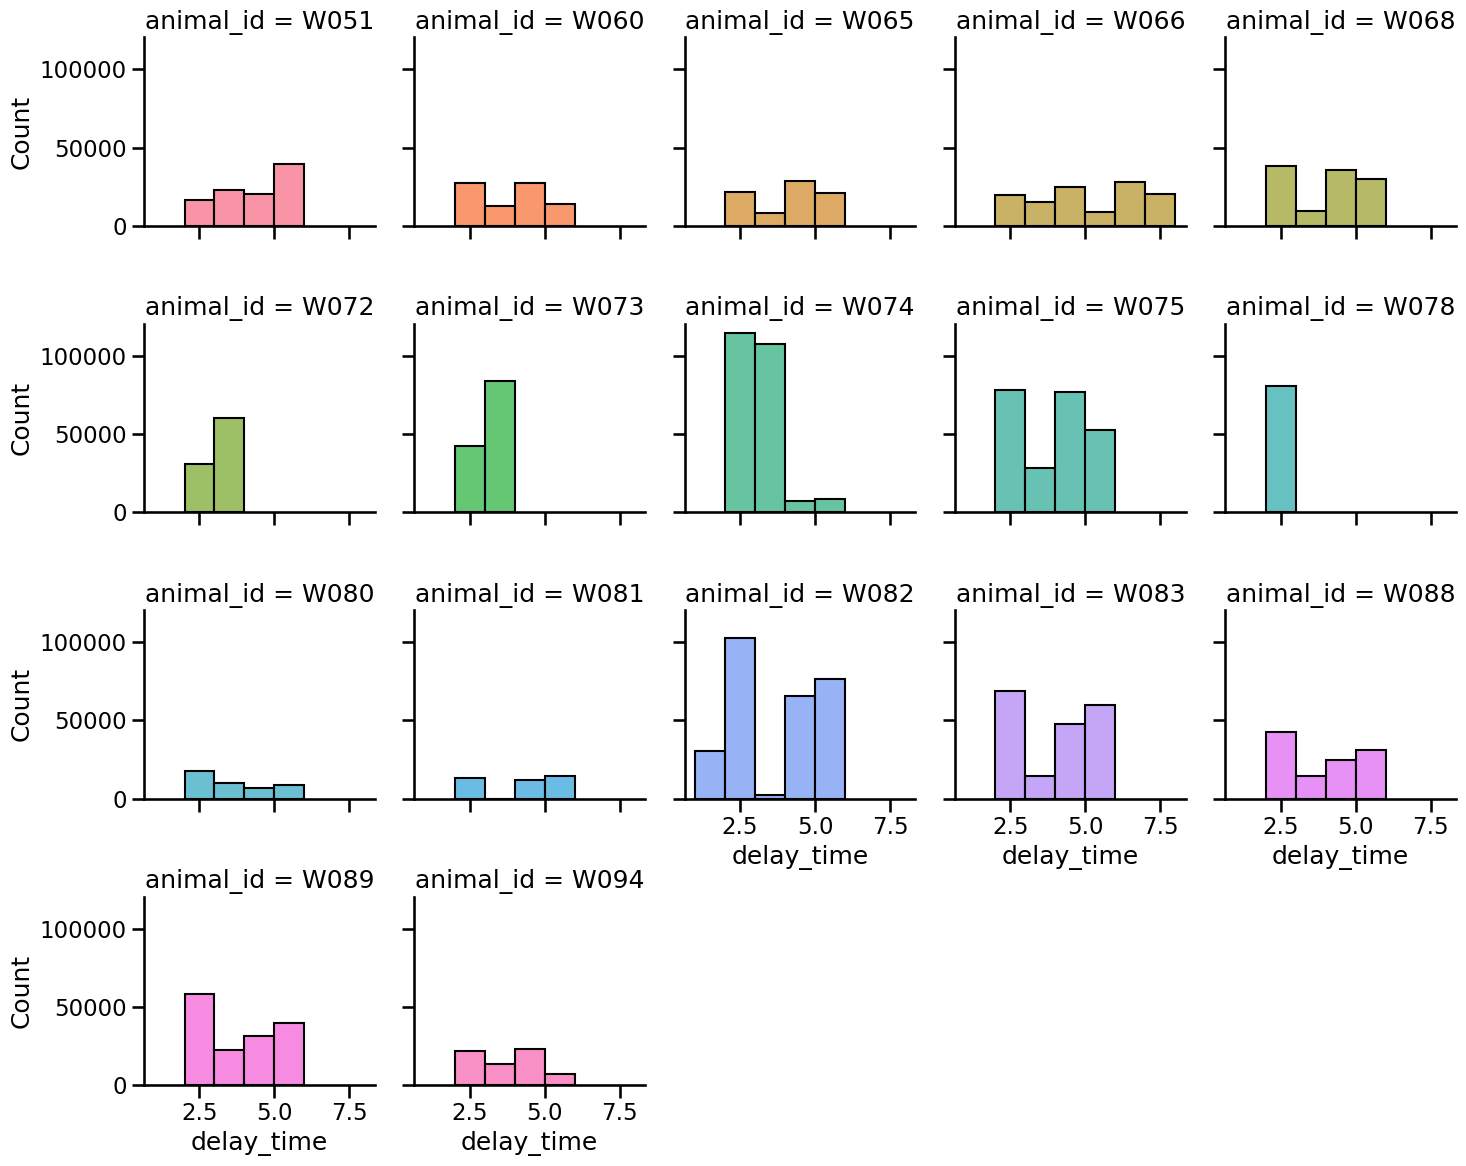

In [30]:
g = sns.FacetGrid(
    data=trained_df,
    col="animal_id",
    hue="animal_id",
    col_wrap=5,
)
g.map(sns.histplot, "delay_time", binwidth=1)

## Performance ~ Delay

### Hits

[Text(0.5, 1.0, 'Stage 3+ Hit Rates ~ Delay'), (0.0, 1.0)]

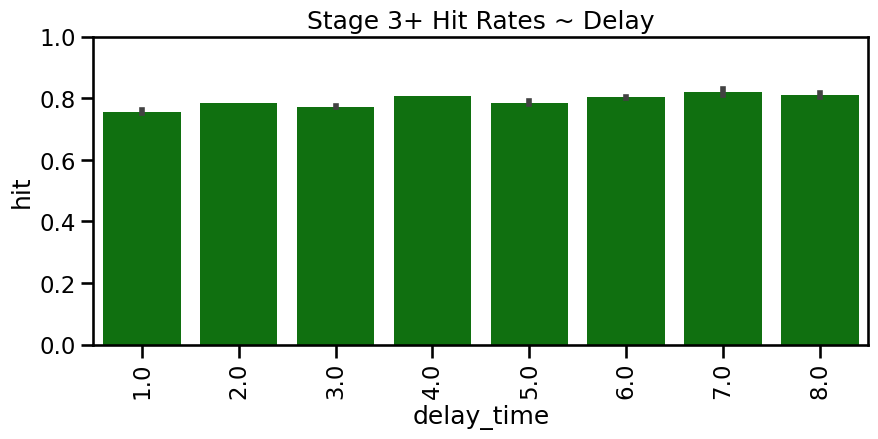

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    data=full_df.query("training_stage >=  3"),
    x="delay_time",
    y="hit",
    color="green",
    ax=ax,
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title="Stage 3+ Hit Rates ~ Delay", ylim=(0, 1))

[Text(0.5, 1.0, 'Trained Hit Rates ~ Delay'), (0.0, 1.0)]

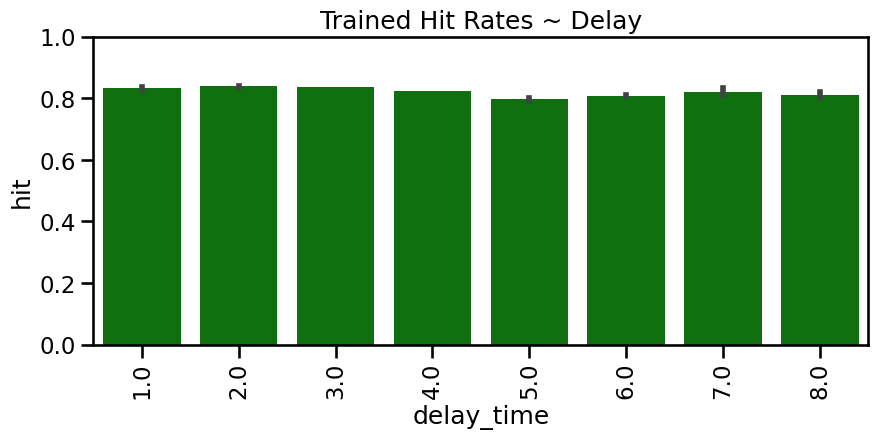

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    data=trained_df,
    x="delay_time",
    y="hit",
    color="green",
    ax=ax,
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title="Trained Hit Rates ~ Delay", ylim=(0, 1))

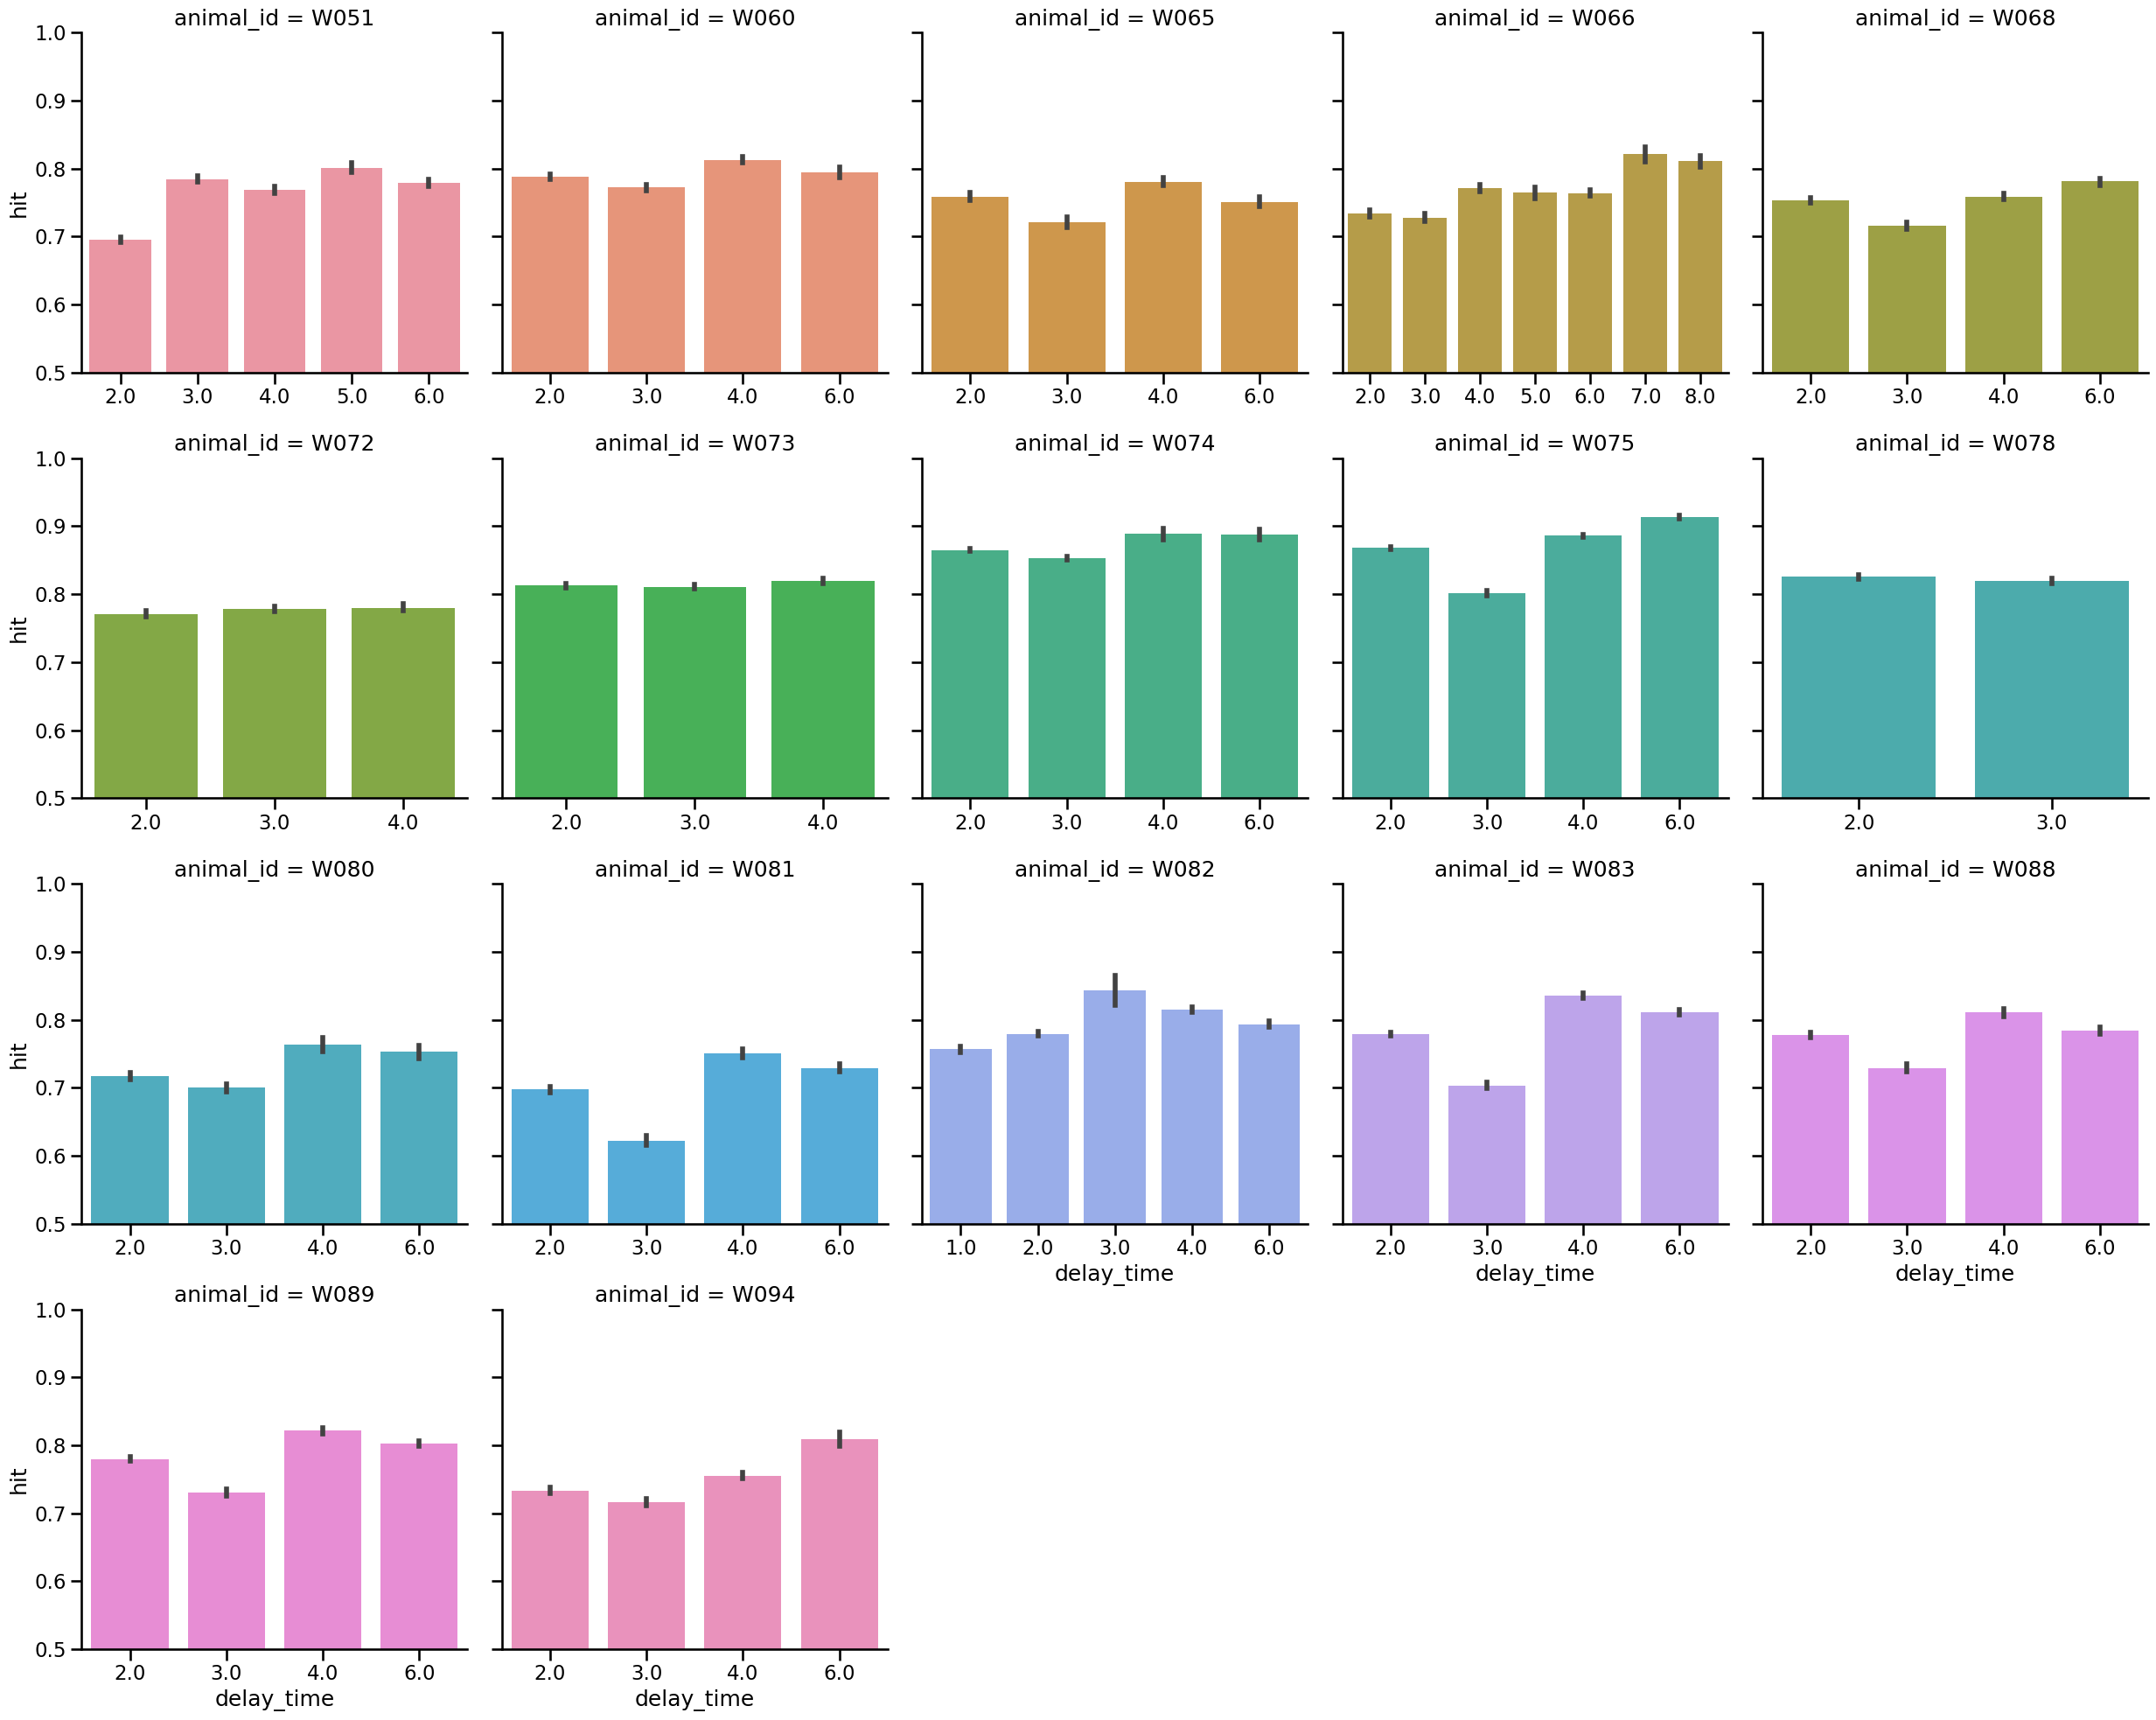

In [13]:
g = sns.catplot(
    x="delay_time",
    y="hit",
    col="animal_id",
    col_wrap=5,
    hue="animal_id",
    data=full_df.query("training_stage >=  3"),
    kind="bar",
    dodge=False,
    sharey=True,
    sharex=False,
)

g.set(ylim=(0.5, 1))

/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


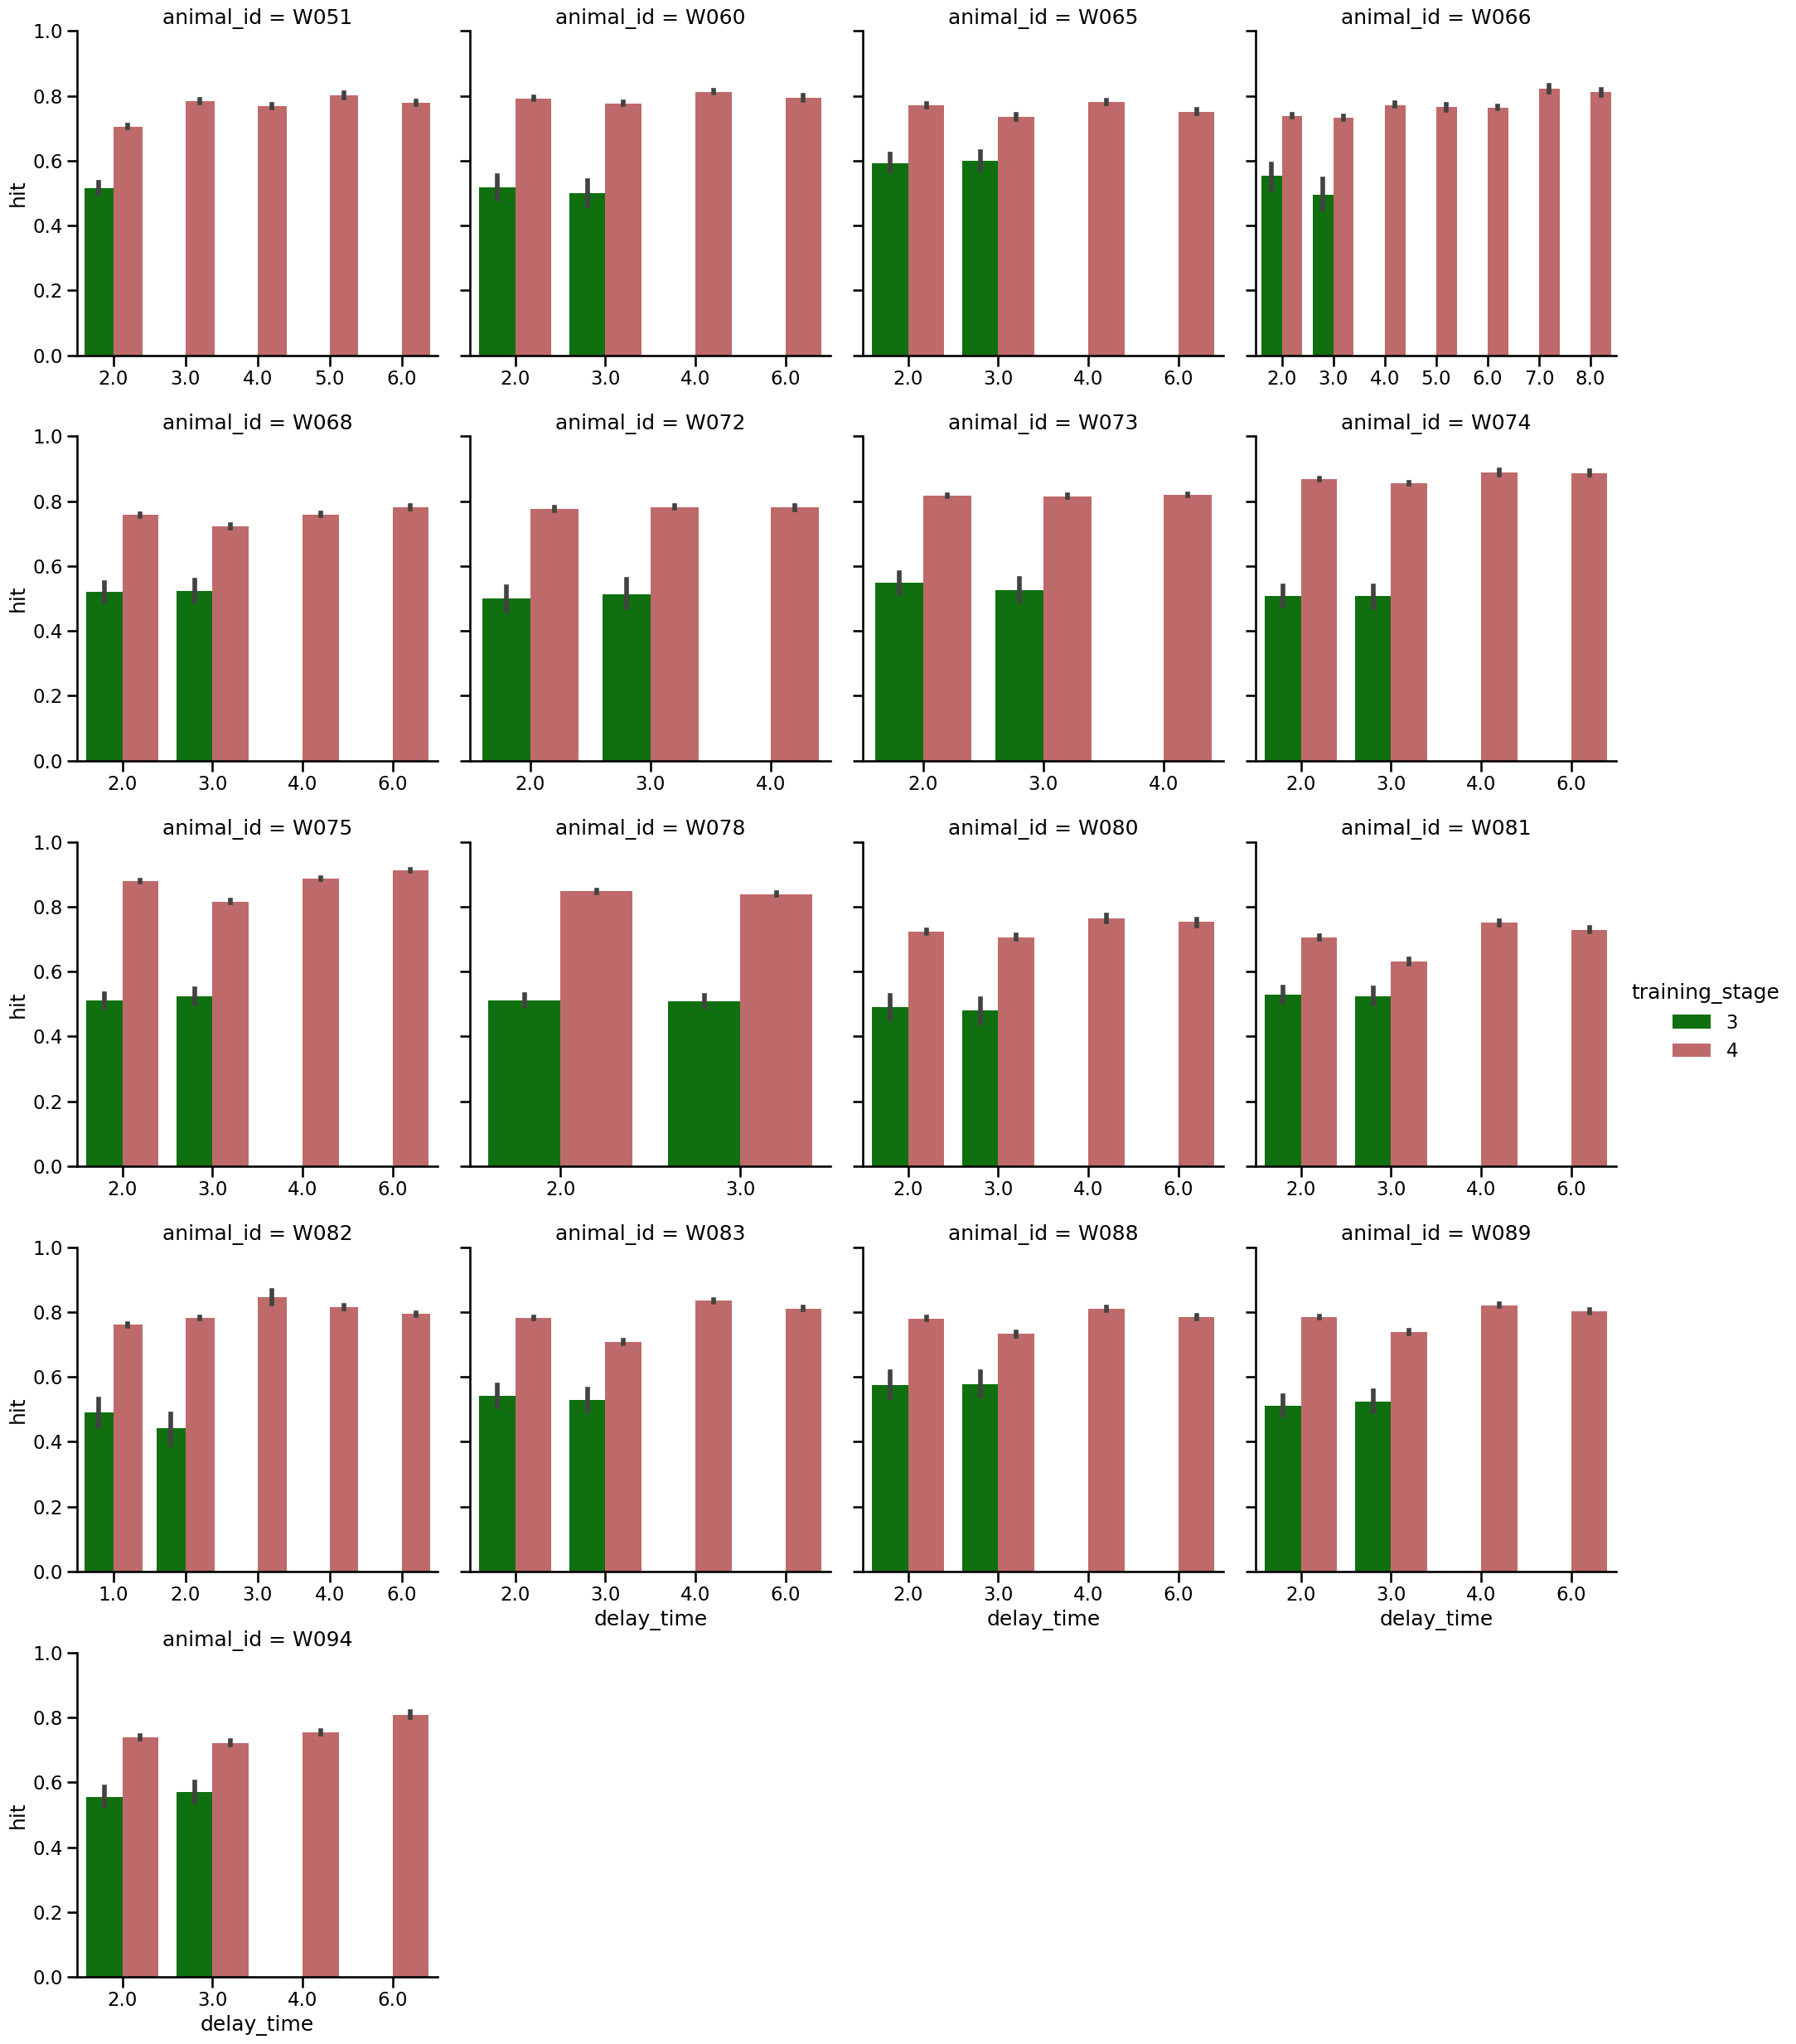

In [16]:
g = sns.catplot(
    x="delay_time",
    y="hit",
    col="animal_id",
    col_wrap=4,
    hue="training_stage",
    data=full_df.query("training_stage >=  3"),
    kind="bar",
    palette=["green", "indianred"],
    dodge=True,
    sharey=True,
    sharex=False,
)

g.set(ylim=(0, 1))

### Violations

<Axes: xlabel='delay_time'>

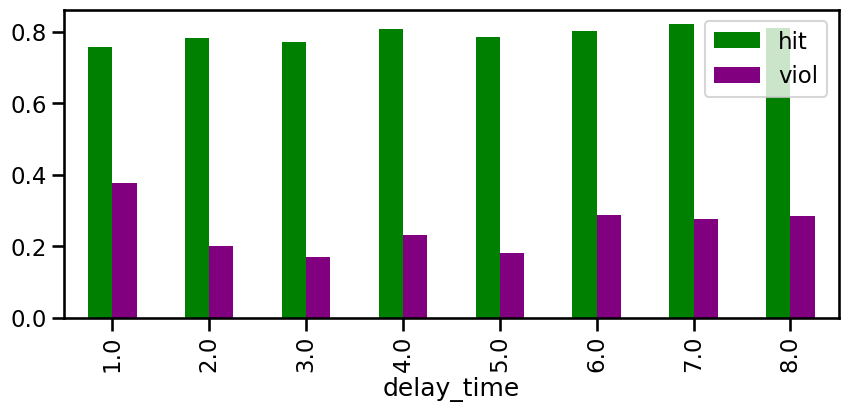

In [15]:
discrete_delay_df = (
    full_df.query("training_stage >=  3")
    .groupby(["delay_time"])
    .hit.mean()
    .reset_index()
)
discrete_delay_df["viol"] = (
    full_df.query("training_stage >=  3")
    .groupby(["delay_time"])
    .violation.mean()
    .values
)
discrete_delay_df.plot(
    kind="bar",
    x="delay_time",
    y=["hit", "viol"],
    color=["green", "purple"],
    figsize=(10, 4),
)

My hypothesis would have been that the longer the delay, the lower the violation rate and hte higher the hit rate. However, these plots suggest this is not the case.

Next notebook: EDA_02_predict_perf


This requires making a large data frame with 

animal id, n delays, viol stage 1-4, hit stage 1-4
Predict time to train

Predict final hit rate